number of parameters: 3416900
self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 2.6575, Test Accuracy: 0.0950, Top5 Accuracy: 0.2800
Epoch 1/1 - v2 Accuracy:0.855 - v4 Accuracy:0.71 - v10 Accuracy:0.475


Results saved to ./generation_metric_outputs/MetaEEG_sub-01.csv
self.subjects ['sub-02']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.2203, Test Accuracy: 0.0250, Top5 Accuracy: 0.0850
Epoch 1/1 - v2 Accuracy:0.67 - v4 Accuracy:0.44 - v10 Accuracy:0.22


Results saved to ./generation_metric_outputs/MetaEEG_sub-02.csv
self.subjects ['sub-03']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.2609, Test Accuracy: 0.0250, Top5 Accuracy: 0.1550
Epoch 1/1 - v2 Accuracy:0.82 - v4 Accuracy:0.6 - v10 Accuracy:0.43


Results saved to ./generation_metric_outputs/MetaEEG_sub-03.csv
self.subjects ['sub-04']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.4969, Test Accuracy: 0.0550, Top5 Accuracy: 0.1800
Epoch 1/1 - v2 Accuracy:0.7 - v4 Accuracy:0.605 - v10 Accuracy:0.34


Results saved to ./generation_metric_outputs/MetaEEG_sub-04.csv
self.subjects ['sub-05']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.1623, Test Accuracy: 0.0150, Top5 Accuracy: 0.1000
Epoch 1/1 - v2 Accuracy:0.695 - v4 Accuracy:0.495 - v10 Accuracy:0.29


Results saved to ./generation_metric_outputs/MetaEEG_sub-05.csv
self.subjects ['sub-06']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.2308, Test Accuracy: 0.0400, Top5 Accuracy: 0.1850
Epoch 1/1 - v2 Accuracy:0.775 - v4 Accuracy:0.55 - v10 Accuracy:0.36


Results saved to ./generation_metric_outputs/MetaEEG_sub-06.csv
self.subjects ['sub-07']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.3026, Test Accuracy: 0.0500, Top5 Accuracy: 0.2150
Epoch 1/1 - v2 Accuracy:0.835 - v4 Accuracy:0.635 - v10 Accuracy:0.38


Results saved to ./generation_metric_outputs/MetaEEG_sub-07.csv
self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.1642, Test Accuracy: 0.1600, Top5 Accuracy: 0.3400
Epoch 1/1 - v2 Accuracy:0.925 - v4 Accuracy:0.8 - v10 Accuracy:0.62


Results saved to ./generation_metric_outputs/MetaEEG_sub-08.csv
self.subjects ['sub-09']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.0791, Test Accuracy: 0.0350, Top5 Accuracy: 0.1950
Epoch 1/1 - v2 Accuracy:0.805 - v4 Accuracy:0.67 - v10 Accuracy:0.4


Results saved to ./generation_metric_outputs/MetaEEG_sub-09.csv
self.subjects ['sub-10']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


Epoch 1/1 - Test Loss: 0.1659, Test Accuracy: 0.0550, Top5 Accuracy: 0.3000
Epoch 1/1 - v2 Accuracy:0.805 - v4 Accuracy:0.7 - v10 Accuracy:0.475


Results saved to ./generation_metric_outputs/MetaEEG_sub-10.csv


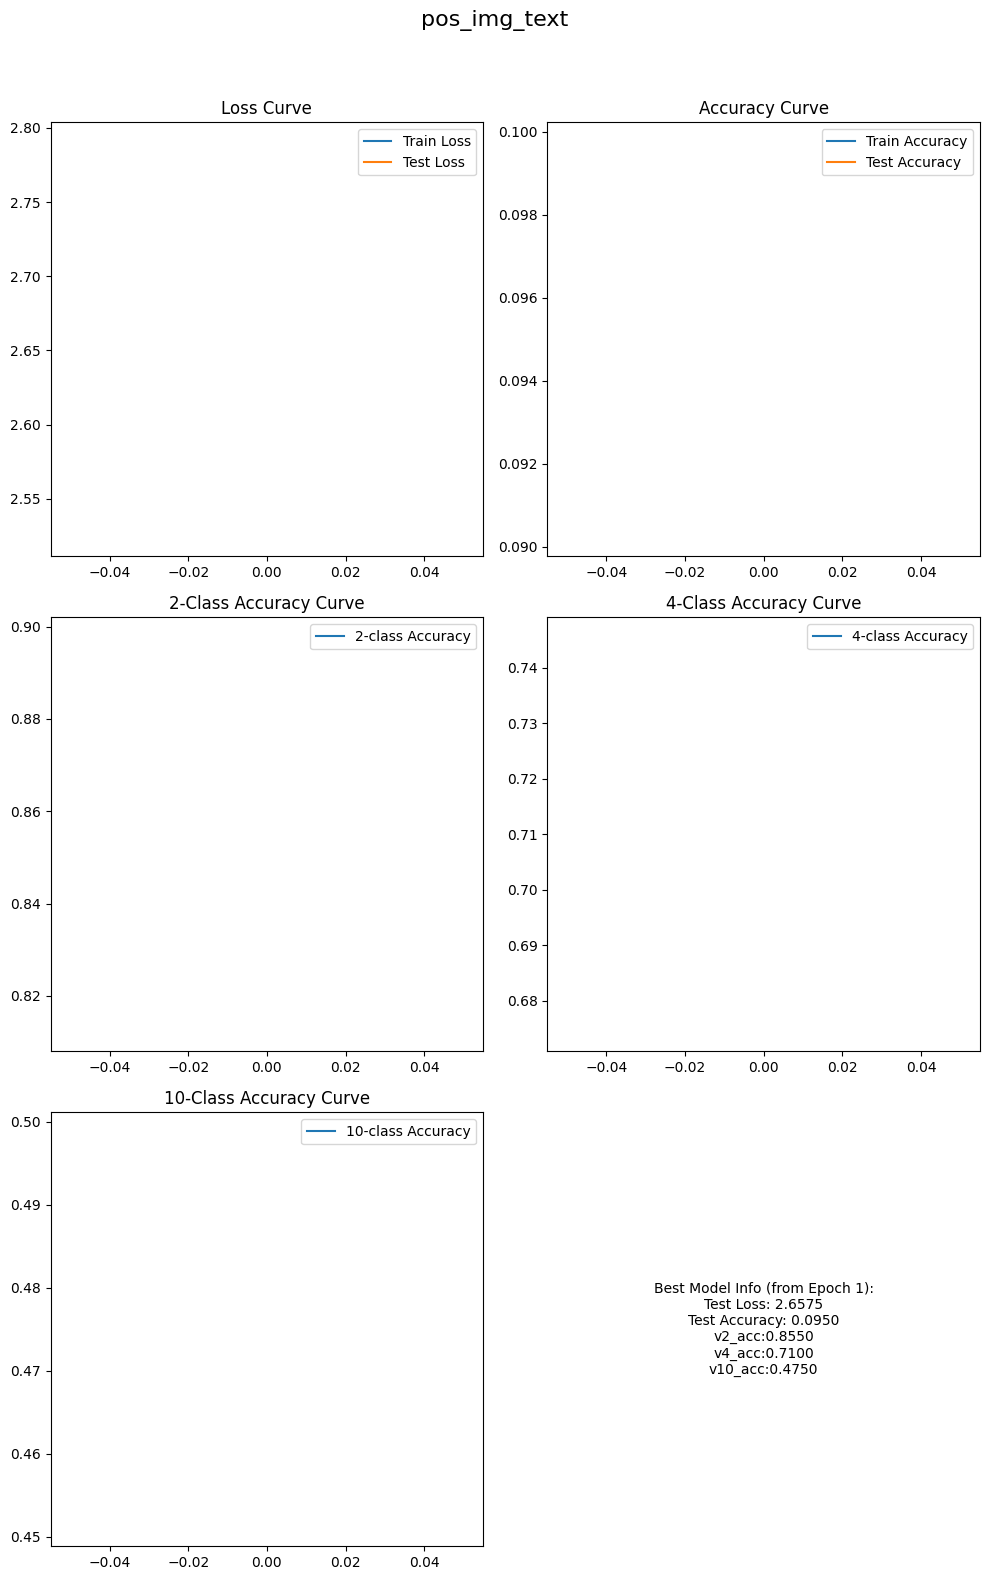

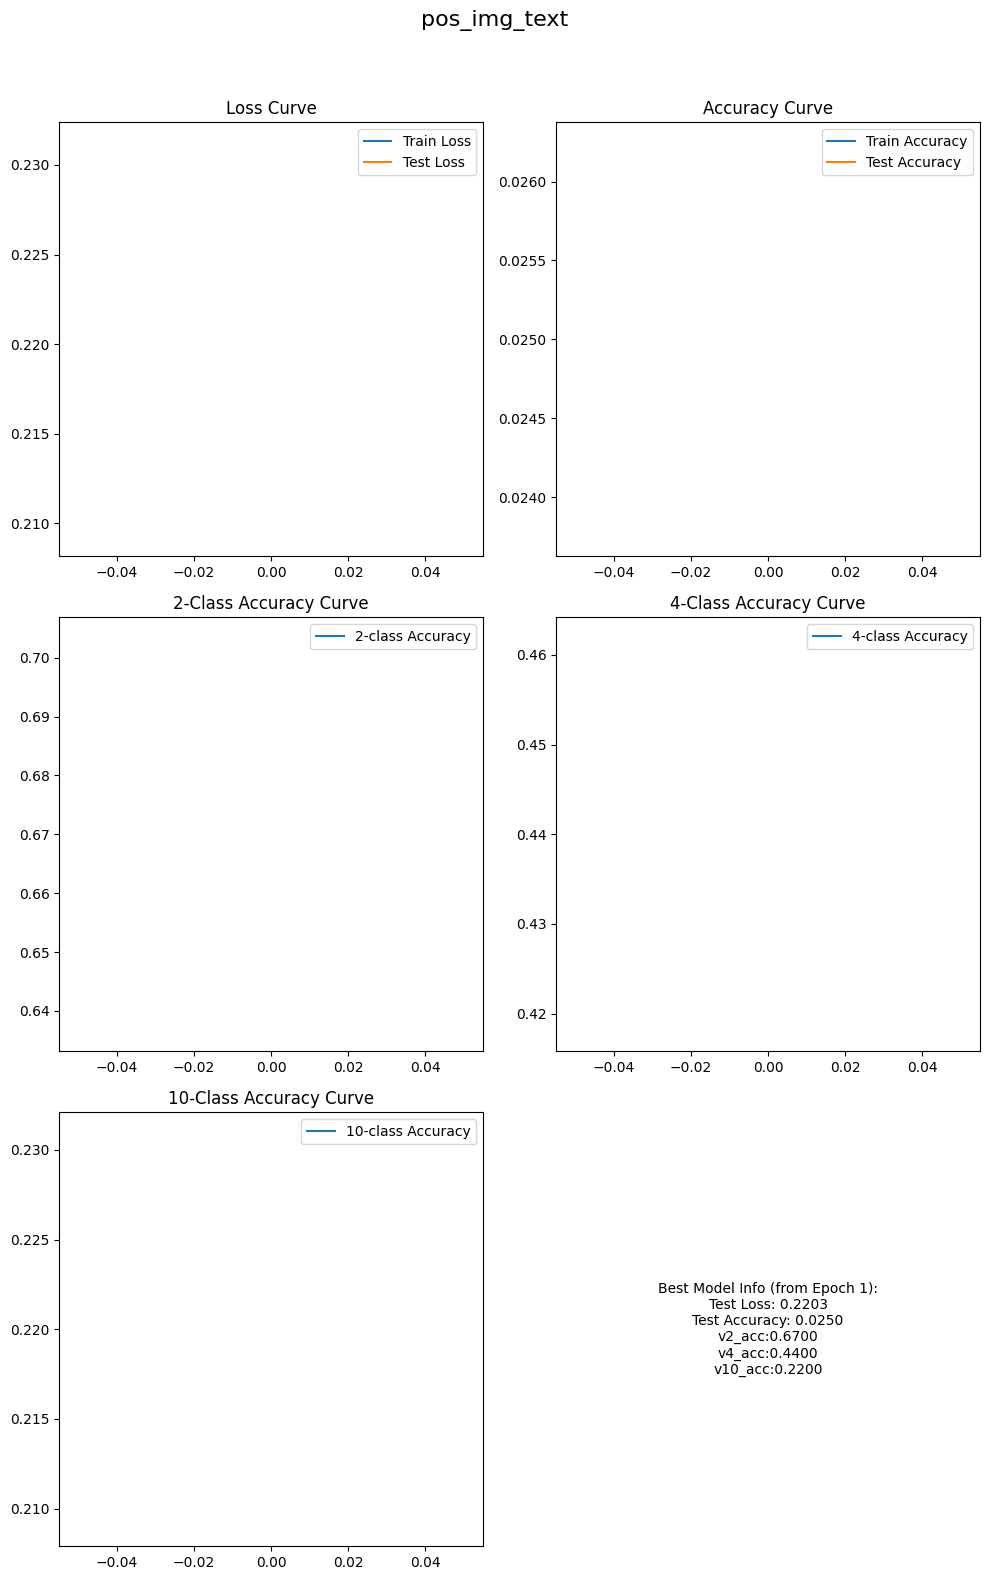

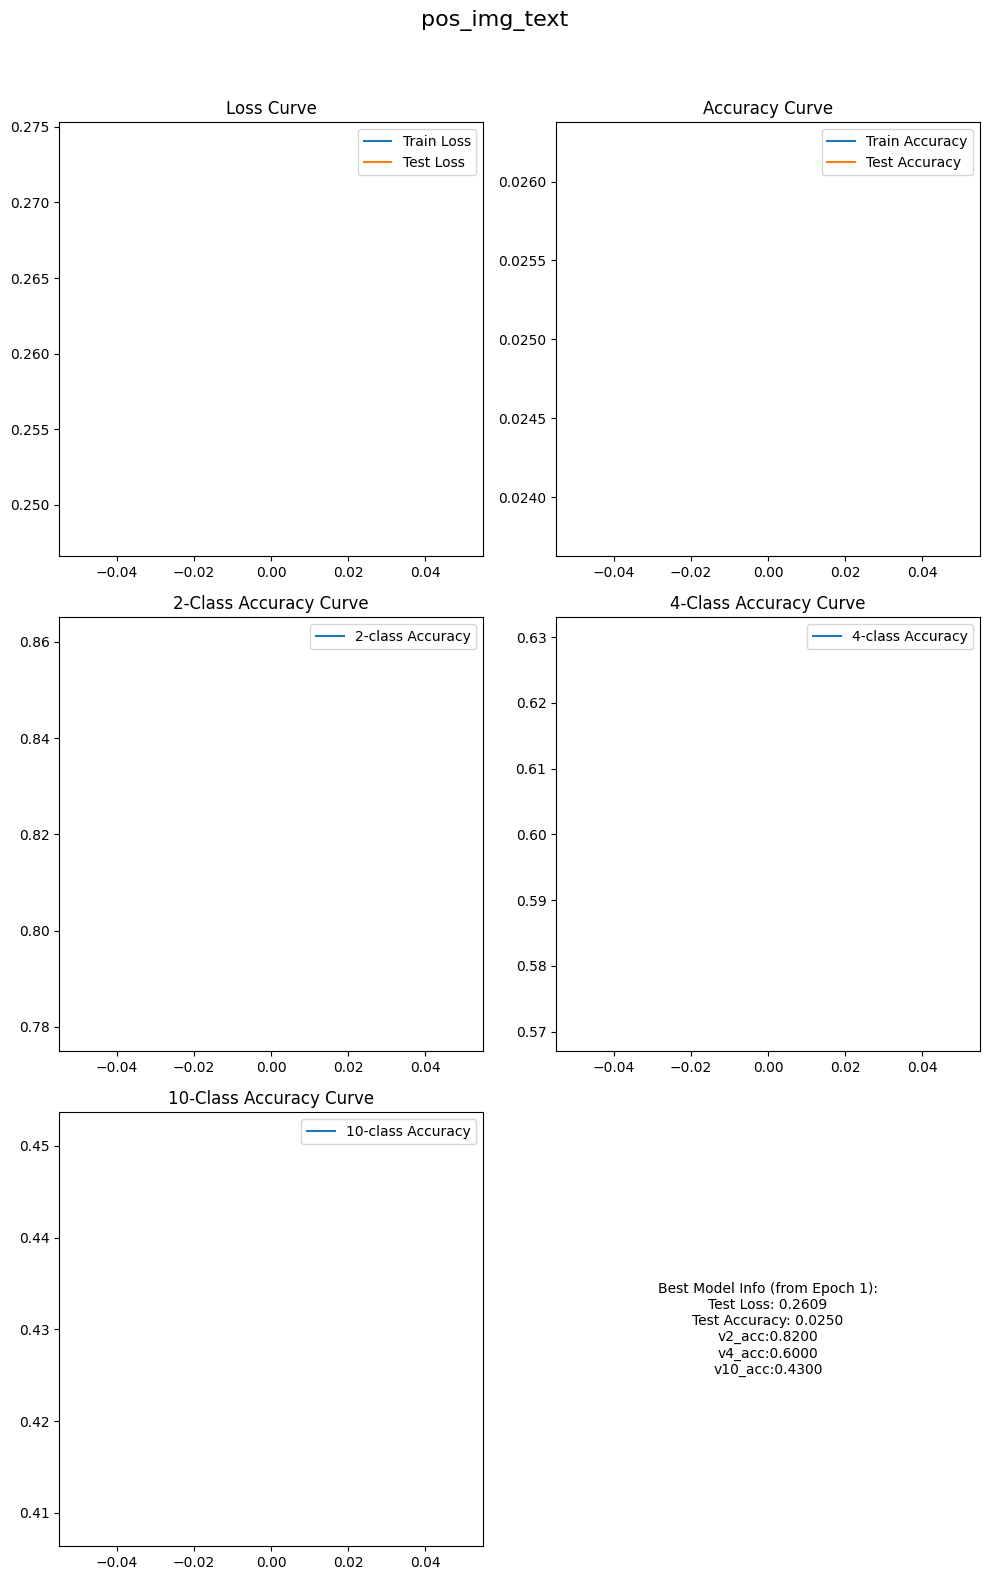

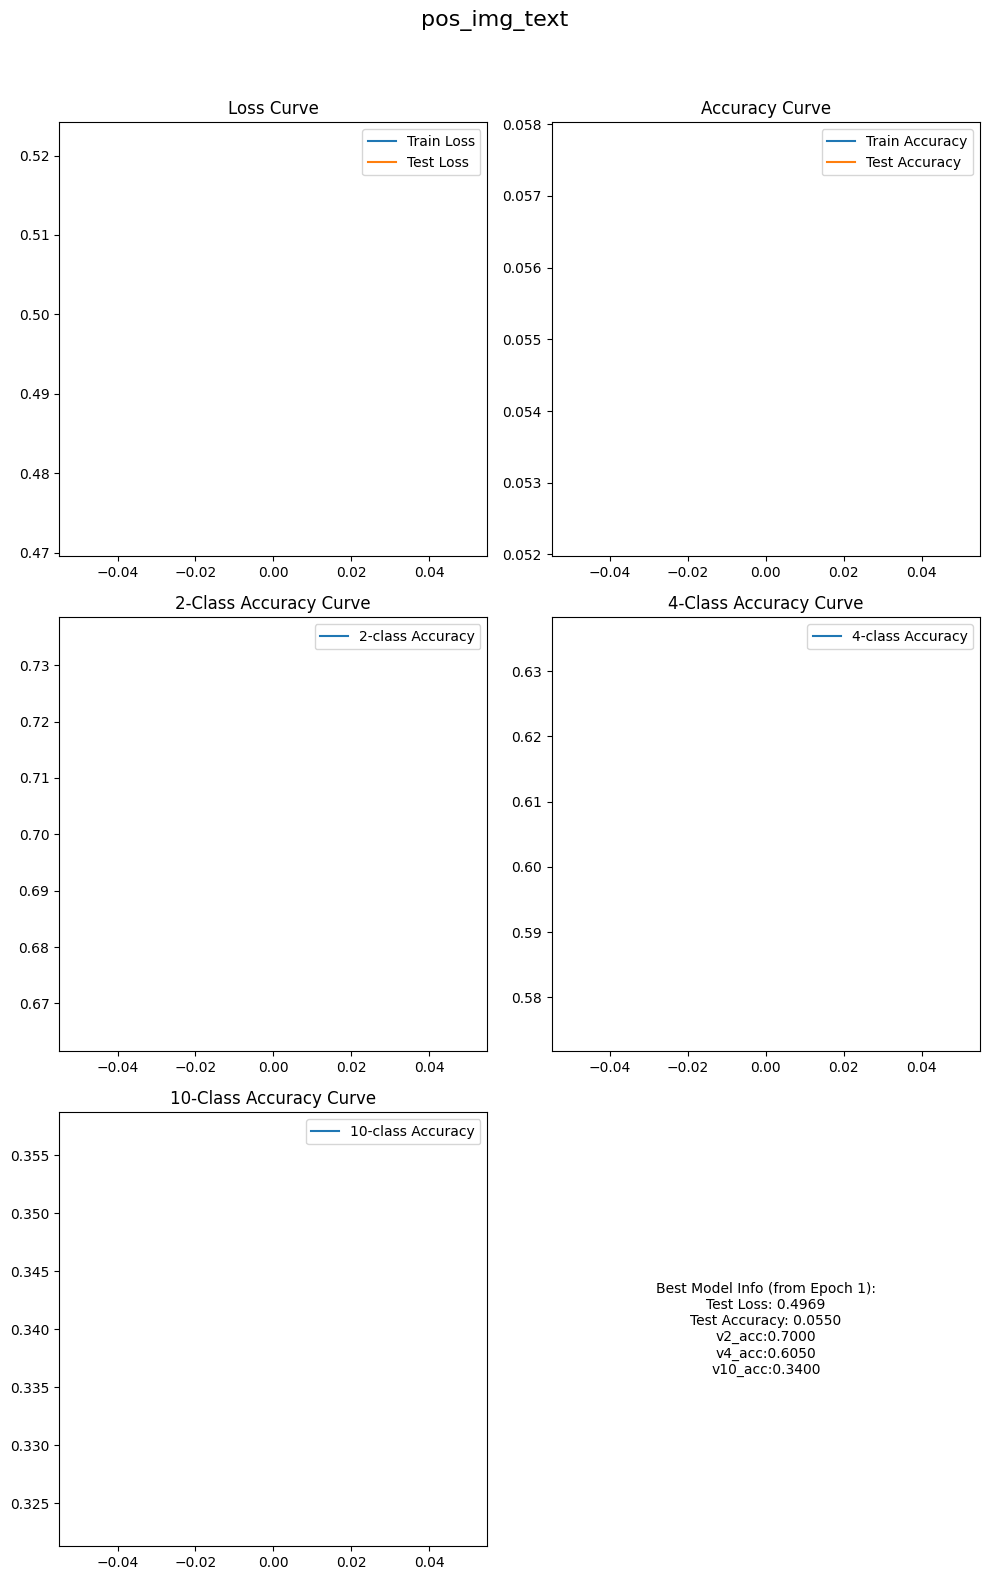

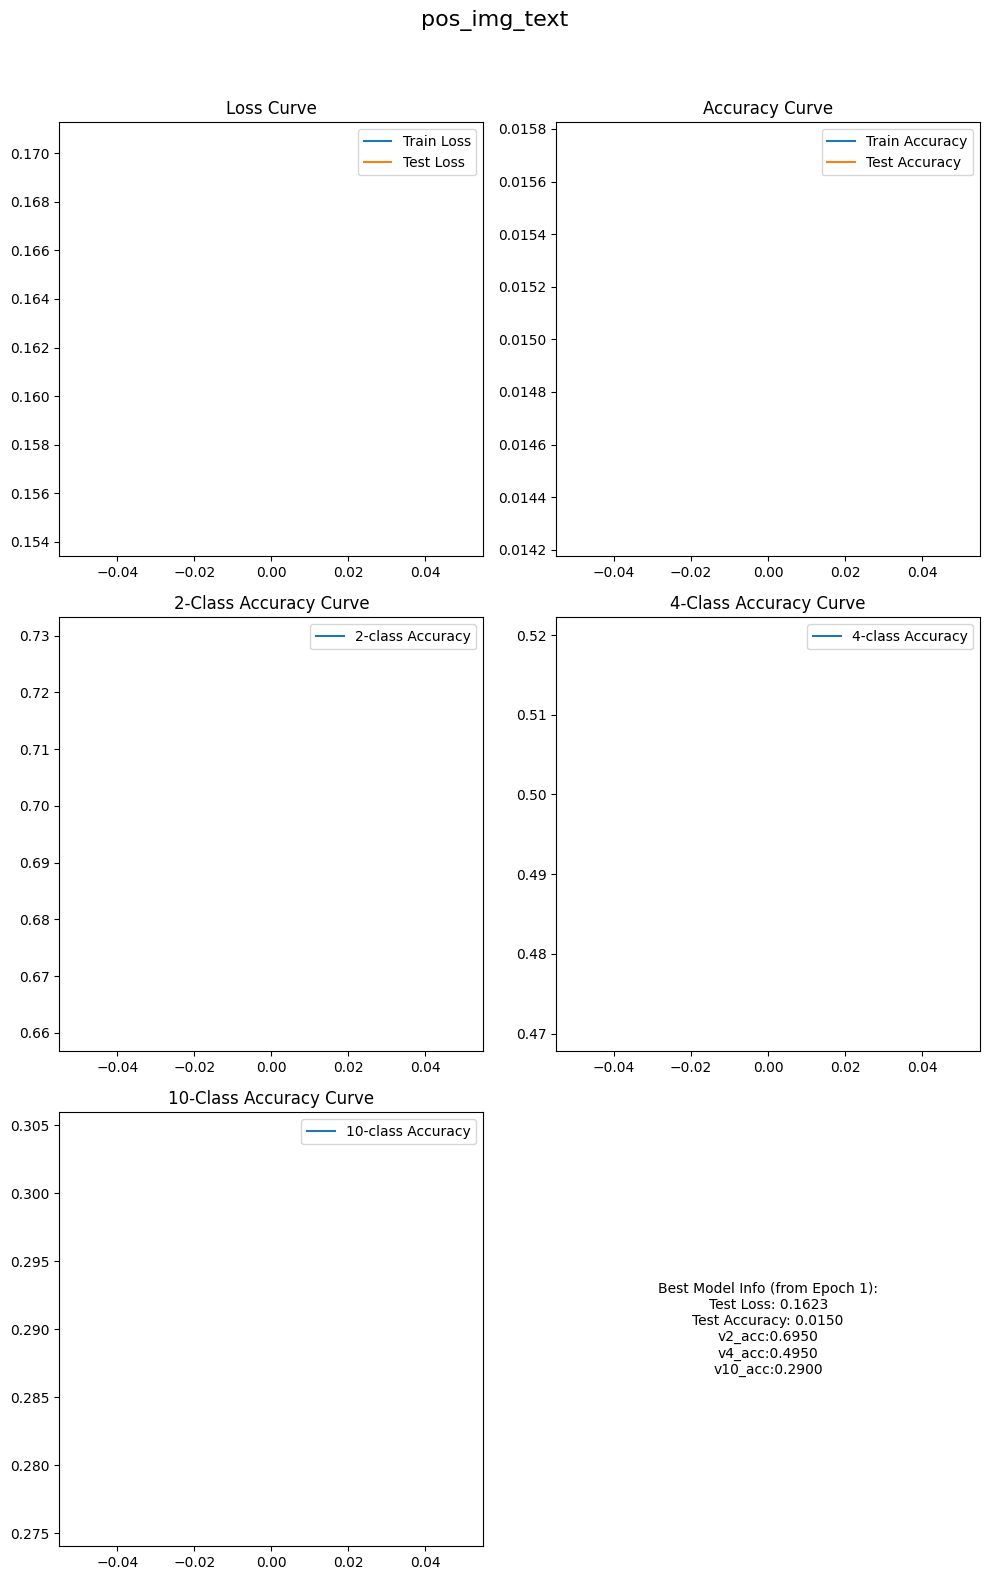

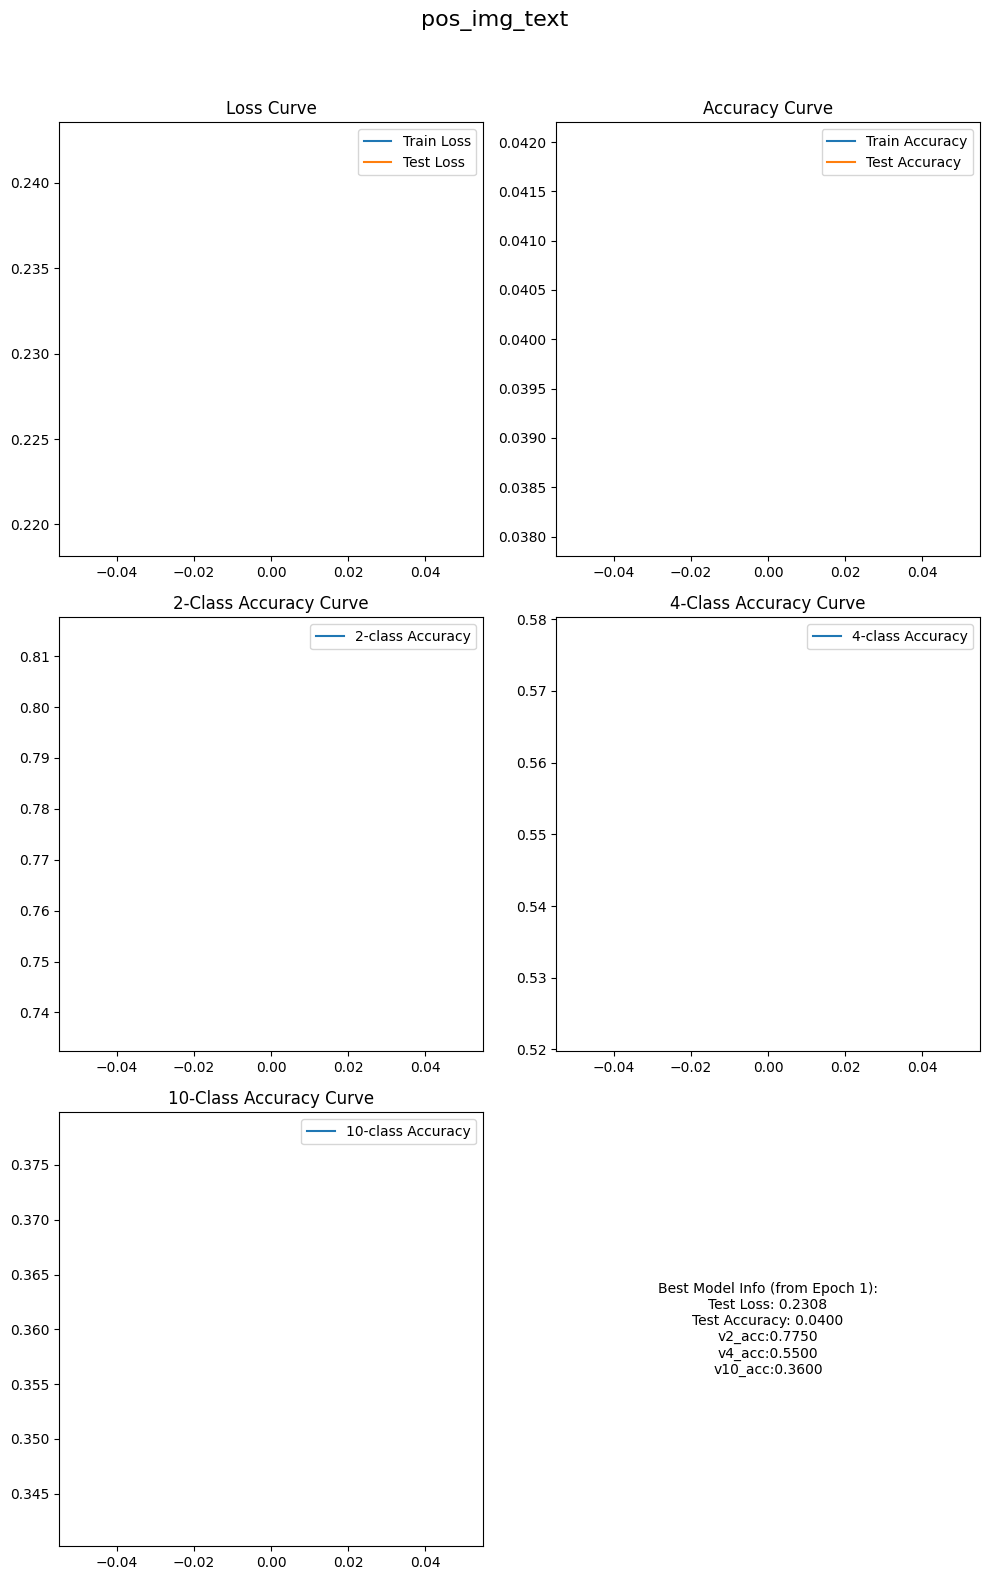

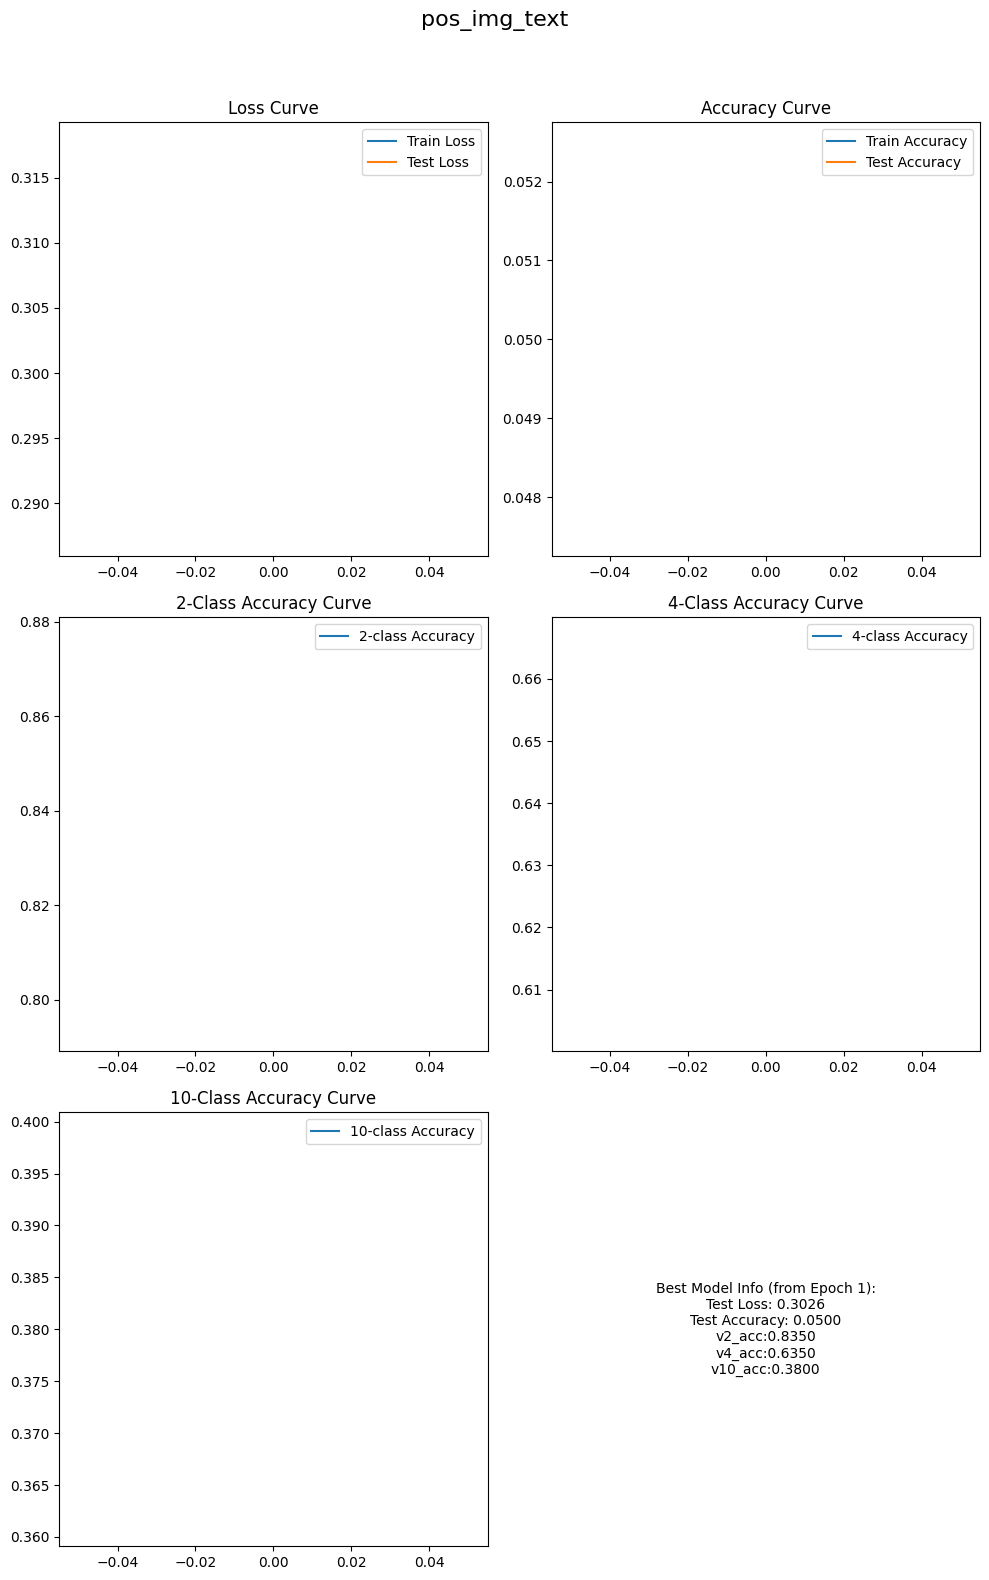

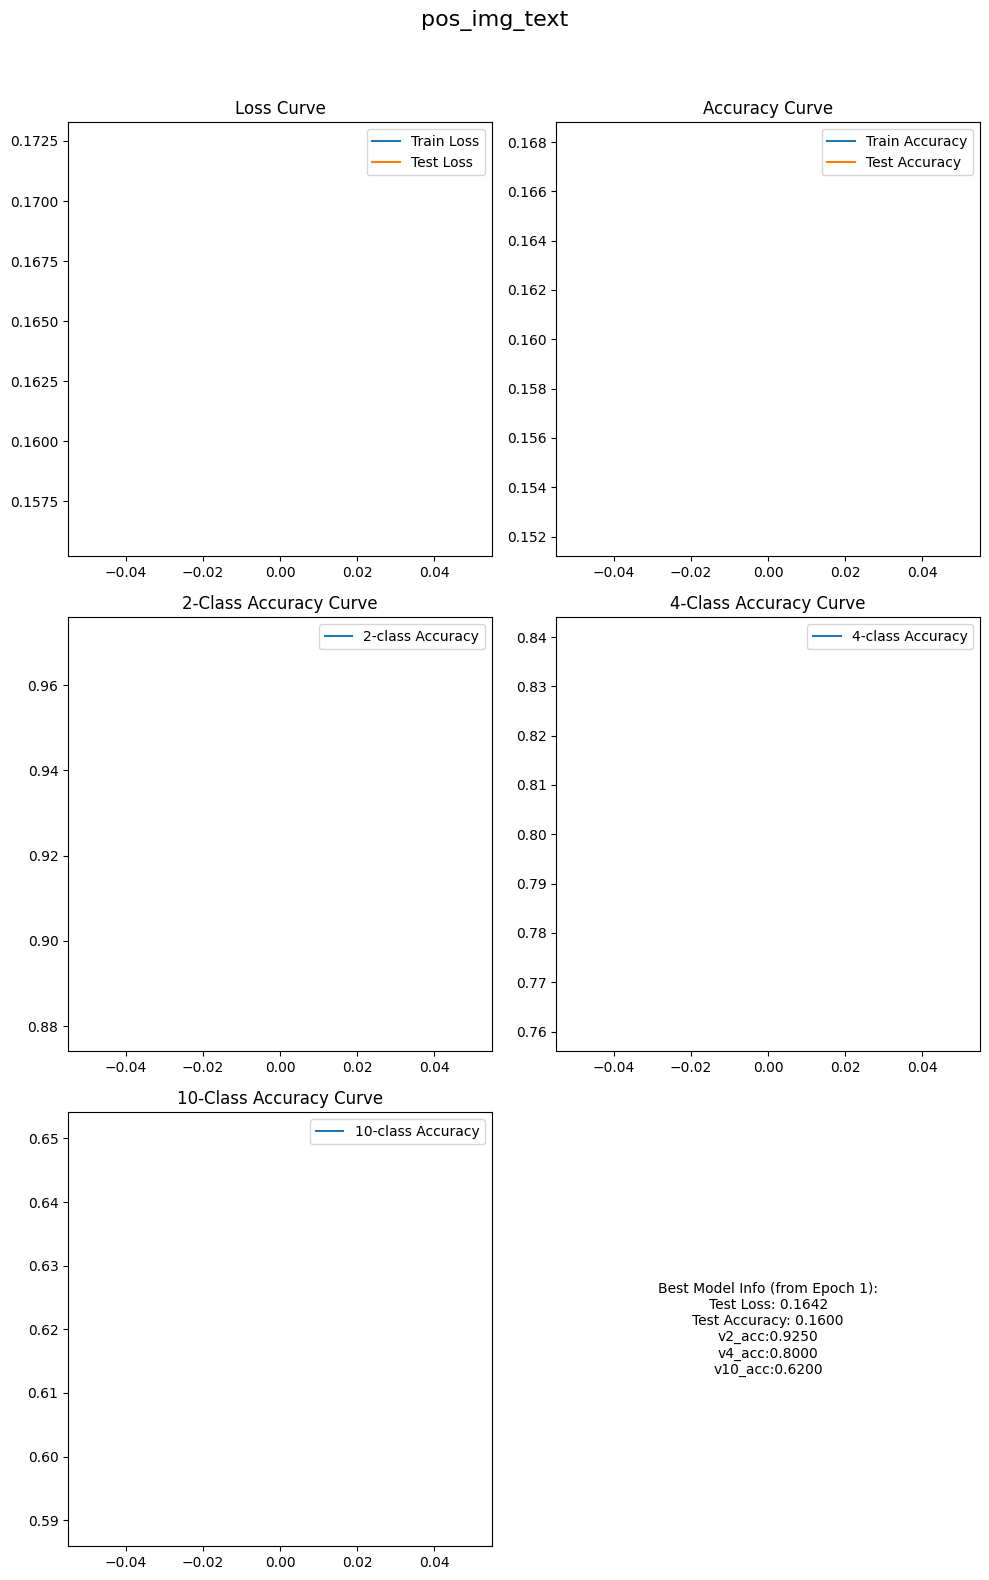

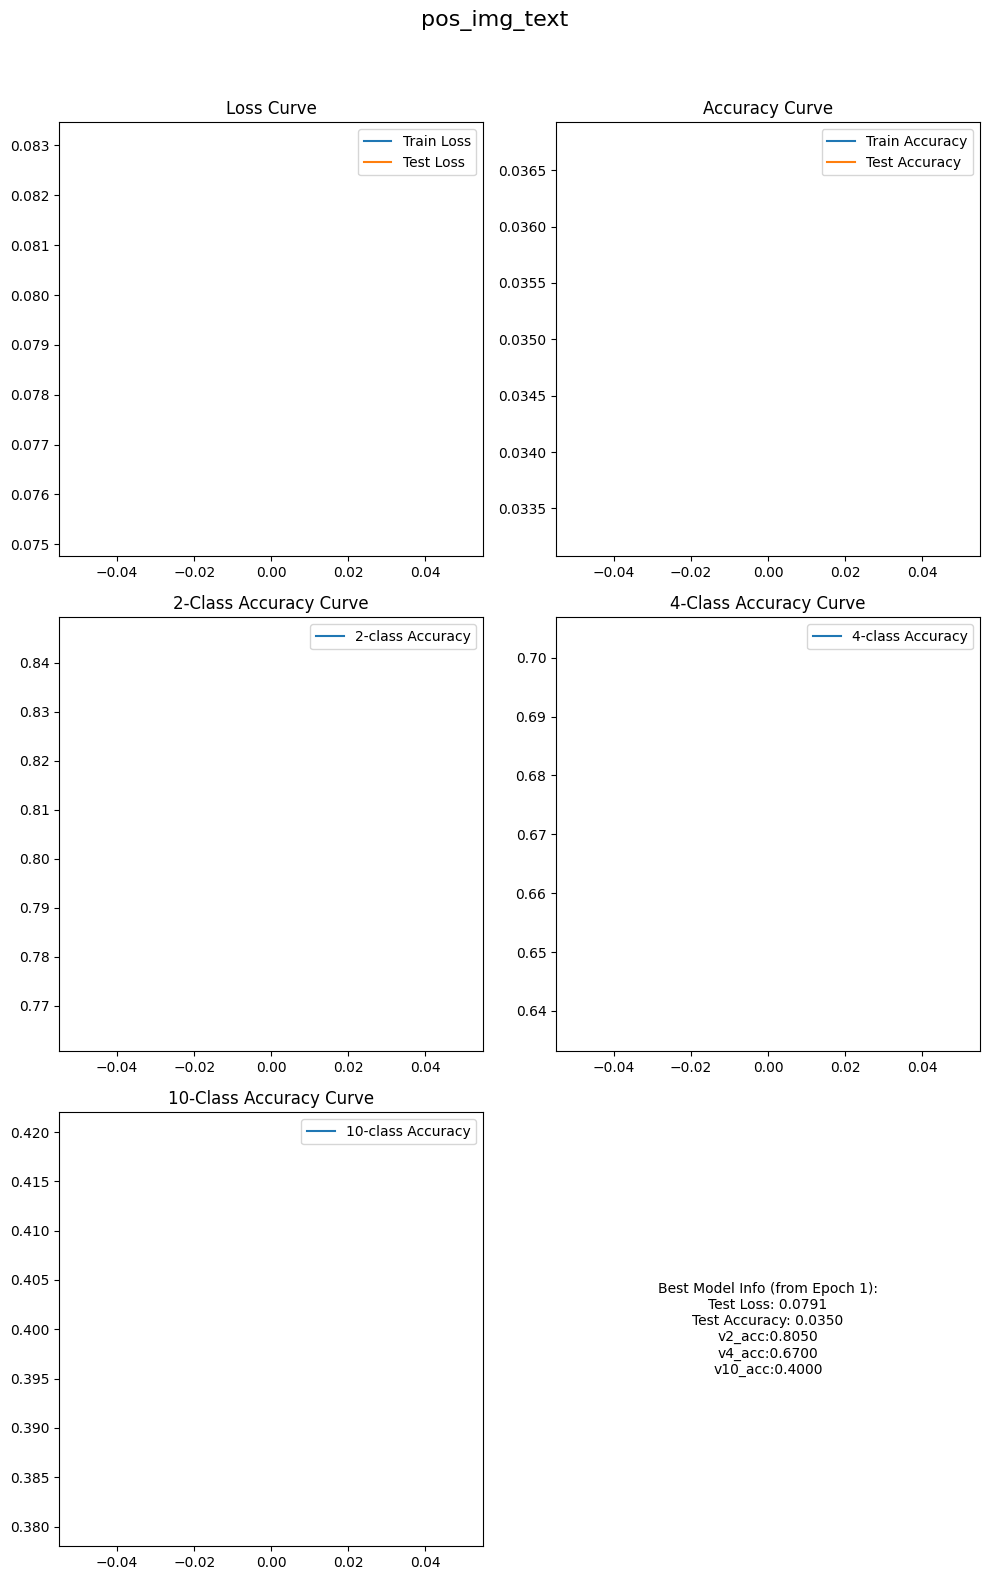

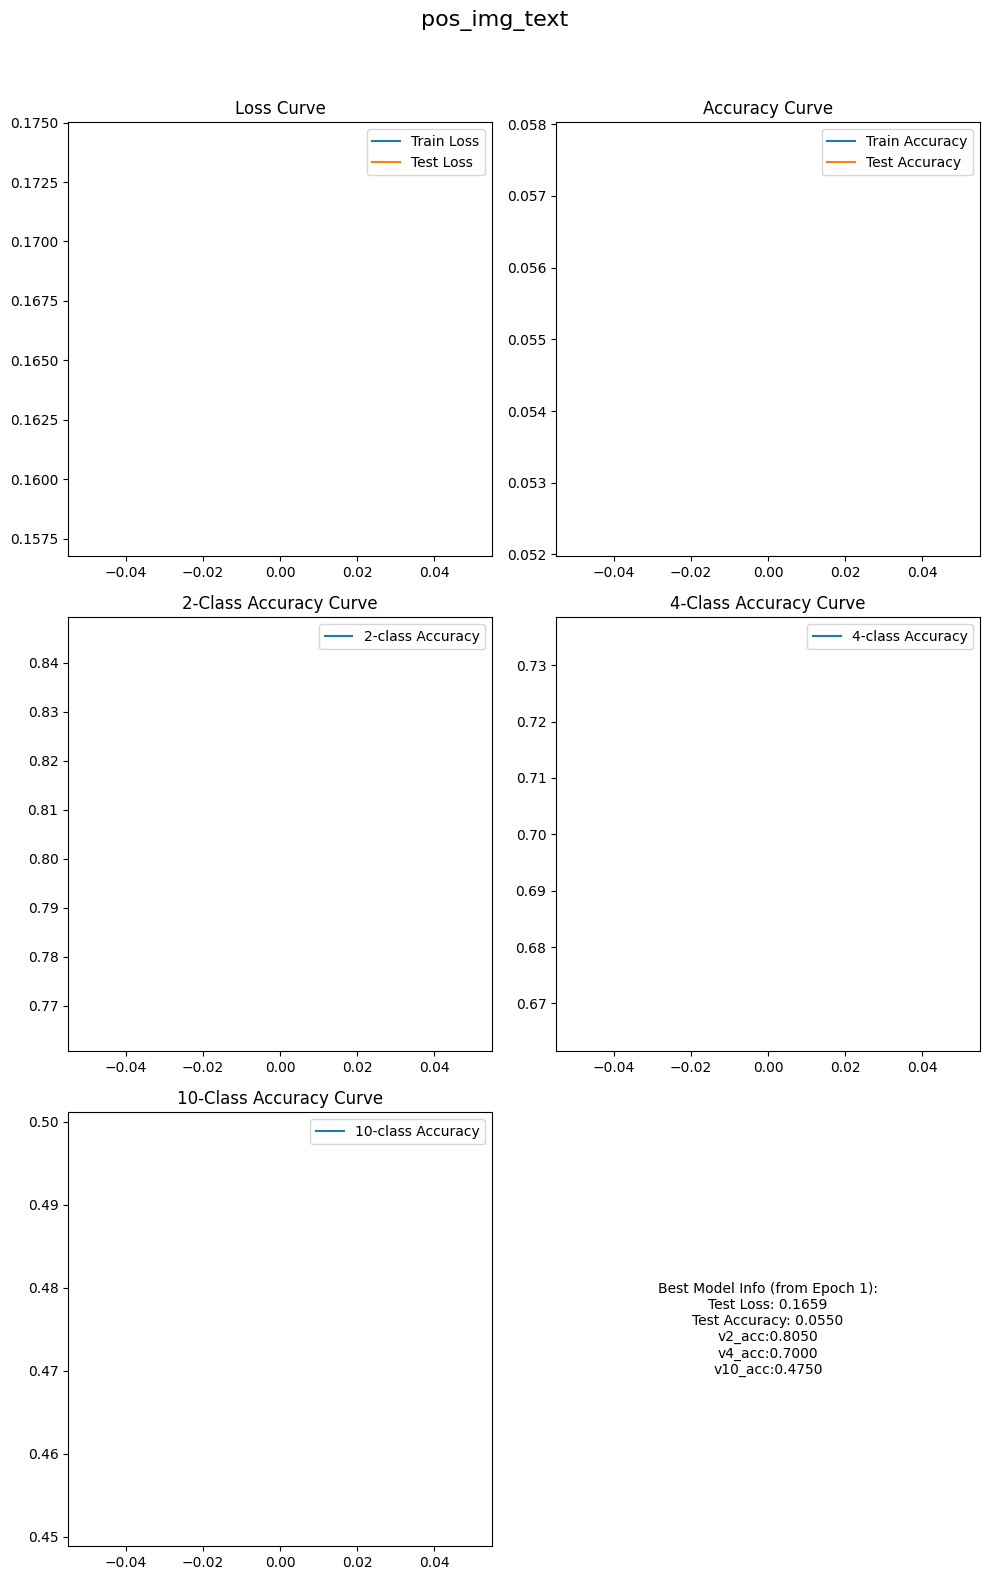

In [3]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone_measure import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from braindecode.models import EEGNetv4, ATCNet, EEGConformer, EEGITNet, ShallowFBCSPNet
import csv
from torch import Tensor
import itertools
import math
import datetime


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model + 1, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term[:d_model // 2 + 1])
        pe[:, 1::2] = torch.cos(position * div_term[:d_model // 2])

        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[:x.size(0), :].unsqueeze(1).repeat(1, x.size(1), 1)
        x = x + pe
        return x




class EEGAttention(nn.Module):
    def __init__(self, channel, d_model, nhead):
        super(EEGAttention, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.channel = channel
        self.d_model = d_model

    def forward(self, src):
        src = src.permute(2, 0, 1)  # Change shape to [time_length, batch_size, channel]
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return output.permute(1, 2, 0)  # Change shape back to [batch_size, channel, time_length]

class MetaEEG(nn.Module):
    def __init__(self, num_channels, sequence_length, num_subjects=1, num_features=64, num_latents=1024, num_blocks=1):
        super(MetaEEG, self).__init__()
        self.attention_model = EEGAttention(num_channels, num_channels, nhead=1)               
        self.subject_wise_linear = nn.ModuleList([nn.Linear(sequence_length, sequence_length) for _ in range(num_subjects)])
        self.conv_blocks = nn.Sequential(*[ConvBlock(num_channels, sequence_length) for _ in range(num_blocks)],
                                         Rearrange('B C L->B L C'))
        self.linear_projection = nn.Sequential(
                                            Rearrange('B L C->B C L'),
                                            nn.Linear(sequence_length, num_latents),
                                            Rearrange('B C L->B L C'))
        self.temporal_aggregation = nn.Linear(sequence_length, 1)
        self.clip_head = MLPHead(num_latents, num_latents)
        self.mse_head = MLPHead(num_latents, num_latents)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.01))
        self.loss_func = ClipLoss()
        
    def forward(self, x, subject_id):
        # print(f'Input shape: {x.shape}')
        # attn_output, _ = self.attention(x, x, x)
       
        x = self.attention_model(x)
        # print(f'After attention shape: {x.shape}')
         
        x = self.subject_wise_linear[subject_id](x)
        # print(f'After subject-specific linear transformation shape: {x.shape}')
        
        x = self.conv_blocks(x)
        # print(f'After convolutional blocks shape: {x.shape}')
        
        # x = self.conv_blocks(x)
        # print(f'After convolutional blocks shape: {x.shape}')
        
        x = self.linear_projection(x)
        # print(f'After linear projection shape: {x.shape}')
        
        x = self.temporal_aggregation(x)
        # print(f'After temporal aggregation shape: {x.shape}')

        clip_out = self.clip_head(x)
        # print(f'Clip head output shape: {clip_out.shape}')
    
        mse_out = self.mse_head(x)
        # print(f'MSE head output shape: {mse_out.shape}')

        return clip_out, mse_out

class ConvBlock(nn.Module):
    def __init__(self, num_channels, num_features):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, num_features, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(num_features, num_features, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(num_features, num_features, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.LayerNorm(num_features)
        self.norm2 = nn.LayerNorm(num_features)
        self.norm3 = nn.LayerNorm(num_features)
        self.residual_conv = nn.Conv1d(num_channels, num_features, kernel_size=1)

    def forward(self, x):
        # print(f'ConvBlock input shape: {x.shape}')
        residual = self.residual_conv(x)
        # residual = x
        # print(f'residual shape: {residual.shape}')
        
        x = F.gelu(self.conv1(x))
        x = self.norm1(x)
        # print(f'After first convolution shape: {x.shape}')
                
        x = F.gelu(self.conv2(x))
        x = self.norm2(x)
        # print(f'After second convolution shape: {x.shape}')
        
        x = F.gelu(self.conv3(x))
        x = self.norm3(x)
        # print(f'After third convolution shape: {x.shape}')
        
        x += residual
        # print(f'ConvBlock output shape: {x.shape}')
        return x

class MLPHead(nn.Module):
    def __init__(self, in_features, num_latents, dropout_rate=0.25):
        super(MLPHead, self).__init__()

        self.layer1 = nn.Sequential(
            Rearrange('B C L->B L C'),
            nn.LayerNorm(in_features),
            nn.Linear(in_features, num_latents),
            nn.GELU(),
            nn.Dropout(dropout_rate), 
            Rearrange('B L C->B (C L)'),
        )
    def forward(self, x):
        # print(f'MLPHead input shape: {x.shape}')
        x = self.layer1(x)
        # print(f'After first layer of MLPHead shape: {x.shape}')
        return x
      

def train_model(eegmodel, imgmodel, dataloader, optimizer, device, text_features_all, img_features_all):
    eegmodel.train()
    text_features_all = text_features_all.to(device).float() # (n_cls, d)
    img_features_all = (img_features_all[::10]).to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha=0.9
    features_list = []  # List to store features
    save_features= True
    ridge_lambda = 0.1
    mse_loss_fn = nn.MSELoss()
    for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
        eeg_data = eeg_data.to(device)
        text_features = text_features.to(device).float()
        img_features = img_features.to(device).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        eeg_features,mse_features = eegmodel(eeg_data, 0)
        # img_features_outputs = regression(eeg_features).float()
        features_list.append(eeg_features)
        logit_scale = eegmodel.logit_scale
        img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
        text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
        contrastive_loss = img_loss
        # print("text_loss", text_loss)
        # print("img_loss", img_loss)
        
        regress_loss =  mse_loss_fn(eeg_features, img_features)
        # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        # loss = (regress_loss + ridge_lambda * l2_norm)       
        loss = (alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()
        
        # logits = logit_scale * eeg_features @ text_features_all.T # (n_batch, n_cls)

        logits_img = logit_scale * eeg_features @ img_features_all.T
        # logits_text = logit_scale * eeg_features @ text_features_all.T
        # logits_single = (logits_text + logits_img) / 2.0        
        # logits_text = logit_scale * eeg_features @ text_features_all.T
        logits_single = logits_img
        predicted = torch.argmax(logits_single, dim=1) # (n_batch, ) \in {0, 1, ..., n_cls-1}

        batch_size = predicted.shape[0]
        total += batch_size
        correct += (predicted == labels).sum().item()

    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy

def evaluate_model(eegmodel, imgmodel, dataloader, device, text_features_all, img_features_all, generated_features_all, k):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0

    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)    
            
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features,mse_features = eegmodel(eeg_data, 0)
            logit_scale = eegmodel.logit_scale                    
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):

                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = generated_features_all[::10][selected_classes]
                # selected_img_features = img_features_all[selected_classes]
                selected_text_features = text_features_all[selected_classes]
                
                if k==200:

                    logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                    logits_single = logits_img
                    # print("logits_single", logits_single.shape)

                    # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                    predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                    if predicted_label == label.item():
                        # print("predicted_label", predicted_label)
                        correct += 1
                    



                    # print("logits_single", logits_single)
                    _, top5_indices = torch.topk(logits_single, 5, largest =True)
                                                           

                    if label.item() in [selected_classes[i] for i in top5_indices.tolist()]:                
                        top5_correct_count+=1                                
                    total += 1
                elif k==2 or k==4 or k==10:

                    logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                    # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                    # logits_single = (logits_text + logits_img) / 2.0
                    logits_single = logits_img
                    # print("logits_single", logits_single.shape)

                    # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                    predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                    if predicted_label == label.item():
                        correct += 1
                    total += 1
                else:
                    print("Error.")
                    
    # print("total_loss", total_loss)
    # print("batch_idx+1", batch_idx+1)                
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    top5_acc = top5_correct_count / total
    return average_loss, accuracy, top5_acc

def main_train_loop(sub, eeg_model, img_model, train_dataloader, test_dataloader, optimizer, device, 
                    text_features_train_all, text_features_test_all, img_features_train_all, img_features_test_all, generated_features_all, config, logger=None):
    logger = wandb_logger(config) if logger else None
    logger.watch(eeg_model,logger) 

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    v2_accs = []
    v4_accs = []
    v10_accs = []

    best_accuracy = 0.0
    best_model_weights = None
    best_epoch_info = {}
    results = []  # List to store results for each epoch
  
    for epoch in range(config['epochs']):

        # train_loss, train_accuracy = train_model(eeg_model, img_model, train_dataloader, optimizer, device, text_features_train_all, img_features_train_all)
        # if (epoch +1) % 5 == 0:               
        #     if config['insubject']==True:       
        #         os.makedirs(f"./models/contrast/{config['encoder_type']}/{sub}/{current_time}", exist_ok=True)             
        #         file_path = f"./models/contrast/{config['encoder_type']}/{sub}/{current_time}/{epoch+1}.pth"
        #         torch.save(eeg_model.state_dict(), file_path)            
        #     else:                
        #         os.makedirs(f"./models/contrast/across/{config['encoder_type']}/{current_time}", exist_ok=True)             
        #         file_path = f"./models/contrast/across/{config['encoder_type']}/{current_time}/{epoch+1}.pth"
        #         torch.save(eeg_model.state_dict(), file_path)
        #     print(f"model saved in {file_path}!")
        # eeg_model.load_state_dict(torch.load(f"/home/ldy/Workspace/BrainAligning_retrieval/models/contrast/NICE/{sub}/40.pth", map_location=device))
        import os
        import glob
        import torch
        from datetime import datetime


        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



        sub_path = f"/home/ldy/Workspace/BrainAligning_retrieval/models/contrast/MetaEEG/{sub}"


        time_folders = glob.glob(os.path.join(sub_path, "*/"))
        if not time_folders:
            raise ValueError(f"No time-named folders found in {sub_path}")


        def parse_folder_time(folder_name):

            try:
                return datetime.strptime(os.path.basename(os.path.normpath(folder_name)), "%m-%d_%H-%M")
            except ValueError:
                return None


        parsed_folders = [(folder, parse_folder_time(folder)) for folder in time_folders]
        parsed_folders = [pf for pf in parsed_folders if pf[1] is not None]


        if not parsed_folders:
            raise ValueError(f"No folders with valid time format found in {sub_path}")


        latest_folder = max(parsed_folders, key=lambda x: x[1])[0]


        final_path = os.path.join(latest_folder, "40.pth")
        if not os.path.exists(final_path):
            raise FileNotFoundError(f"File {final_path} does not exist")


        eeg_model.load_state_dict(torch.load(final_path, map_location=device))

        eeg_model = eeg_model.to(device)
        generated_features_all = generated_features_all.to(device)
        img_model = None
        # eegmodel.eval()
        test_loss, test_accuracy, top5_acc = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k=200)
        _, v2_acc, _ = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k = 2)
        _, v4_acc, _ = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k = 4)
        _, v10_acc, _ = evaluate_model(eeg_model, img_model, test_dataloader, device, text_features_test_all, img_features_test_all, generated_features_all, k = 10)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        v2_accs.append(v2_acc)
        v4_accs.append(v4_acc)
        v10_accs.append(v10_acc)
        # Append results for this epoch
        epoch_results = {
        "epoch": epoch + 1,
        # "train_loss": train_loss,
        # "train_accuracy": train_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "v2_acc": v2_acc,
        "v4_acc": v4_acc,
        "v10_acc": v10_acc,
        "top5_acc":top5_acc
        }
        results.append(epoch_results)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            # best_model_weights = model.state_dict().copy()
            
            best_epoch_info = {
                "epoch": epoch + 1,
                # "train_loss": train_loss,
                # "train_accuracy": train_accuracy,
                "test_loss": test_loss,
                "test_accuracy": test_accuracy,
                "v2_acc":v2_acc,
                "v4_acc":v4_acc,
                "v10_acc":v10_acc
            }
        logger.log({
            # "Train Loss": train_loss,
            # "Train Accuracy": train_accuracy,
            "Test Loss": test_loss,
            "Test Accuracy": test_accuracy,
            "v2 Accuracy": v2_acc,
            "v4 Accuracy": v4_acc,
            "v10 Accuracy": v10_acc,
            "Epoch": epoch
        })

        print(f"Epoch {epoch + 1}/{config['epochs']} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Top5 Accuracy: {top5_acc:.4f}")
        print(f"Epoch {epoch + 1}/{config['epochs']} - v2 Accuracy:{v2_acc} - v4 Accuracy:{v4_acc} - v10 Accuracy:{v10_acc}")
  

    # model.load_state_dict(best_model_weights)


    # torch.save(model.state_dict(), '{train_pos_img_text}.pth')


    fig, axs = plt.subplots(3, 2, figsize=(10, 15))


    axs[0, 0].plot(train_losses, label='Train Loss')
    axs[0, 0].plot(test_losses, label='Test Loss')
    axs[0, 0].legend()
    axs[0, 0].set_title("Loss Curve")


    axs[0, 1].plot(train_accuracies, label='Train Accuracy')
    axs[0, 1].plot(test_accuracies, label='Test Accuracy')
    axs[0, 1].legend()
    axs[0, 1].set_title("Accuracy Curve")



    axs[1, 0].plot(v2_accs, label='2-class Accuracy')
    axs[1, 0].legend()
    axs[1, 0].set_title("2-Class Accuracy Curve")


    axs[1, 1].plot(v4_accs, label='4-class Accuracy')
    axs[1, 1].legend()
    axs[1, 1].set_title("4-Class Accuracy Curve")


    axs[2, 0].plot(v10_accs, label='10-class Accuracy')
    axs[2, 0].legend()
    axs[2, 0].set_title("10-Class Accuracy Curve")


    info_text = (f"Best Model Info (from Epoch {best_epoch_info['epoch']}):\n"
                # f"Train Loss: {best_epoch_info['train_loss']:.4f}\n"
                # f"Train Accuracy: {best_epoch_info['train_accuracy']:.4f}\n"
                f"Test Loss: {best_epoch_info['test_loss']:.4f}\n"
                f"Test Accuracy: {best_epoch_info['test_accuracy']:.4f}\n"
                f"v2_acc:{best_epoch_info['v2_acc']:.4f}\n"
                f"v4_acc:{best_epoch_info['v4_acc']:.4f}\n"
                f"v10_acc:{best_epoch_info['v10_acc']:.4f}")

    axs[2, 1].axis('off')  
    axs[2, 1].text(0.5, 0.5, info_text, fontsize=10, ha='center', va='center', transform=axs[2, 1].transAxes)

    plt.tight_layout()


    plt.suptitle('pos_img_text', fontsize=16, y=1.05)
    plt.savefig('pos_img_text')
    logger.finish()
    return results



def main():
    Encoder_list = ['EEGNetv4_Encoder', 'ATCNet_Encoder', 'EEGConformer_Encoder', 'EEGITNet_Encoder', 'ShallowFBCSPNet_Encoder'] 
    config = {
    "data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
    "project": "train_pos_img_text_rep",
    "entity": "sustech_rethinkingbci",
    "name": "lr=3e-4_img_pos_pro_eeg",
    "lr": 3e-4,
    "epochs": 1,
    "batch_size": 1024,
    "logger": True,
    "insubject": True,
    "encoder_type": 'MetaEEG',
    "img_encoder": 'Proj_img'
    }

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
    
    for sub in subjects:                    
        # Instantiate a new model for each subject
        eeg_model = globals()[config['encoder_type']](63, 250)
        eeg_model.to(device)

        # Reinitialize the optimizer for the new model
        optimizer = torch.optim.AdamW(eeg_model.parameters(), lr=config['lr'])

        if config['insubject']:
            train_dataset = None
            test_dataset = EEGDataset(config['data_path'], subjects=[sub], train=False)
        else:
            train_dataset = EEGDataset(config['data_path'], exclude_subject=sub, train=True)
            test_dataset = EEGDataset(config['data_path'], exclude_subject=sub, train=False)

        train_loader = None if config['insubject'] else DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0, drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

        text_features_train_all = None if config['insubject'] else train_dataset.text_features
        img_features_train_all = None if config['insubject'] else train_dataset.img_features
        text_features_test_all = test_dataset.text_features
        img_features_test_all = test_dataset.img_features        
        generated_features_all = test_dataset.generated_features

        results = main_train_loop(sub, eeg_model, None, train_loader, test_loader, optimizer, device, 
                                  text_features_train_all, text_features_test_all, 
                                  img_features_train_all, img_features_test_all, 
                                  generated_features_all, config, logger=config['logger'])

        # Save results to a CSV file
        results_file = f'./generation_metric_outputs/{config["encoder_type"]}_{"in" if config["insubject"] else "cross_exclude_"}{sub}.csv'
        with open(results_file, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=results[0].keys())
            writer.writeheader()
            writer.writerows(results)
        print(f'Results saved to {results_file}')
            
if __name__ == '__main__':
    main()